In [10]:

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import random
import math
import my_lib_santanastasio as my
import numpy.random as ran #serve per creare dataset

from numpy import sqrt,floor,sin,exp #servono per le derivate
from scipy import stats
from __future__ import division
from sympy import *
from scipy.stats import chi2

# Funzioni

In [11]:
# data = set di dati
# n_mis = numero di misurazioni
# return: media, std_x, std_media
def get_distribution(data,n_mis):
    
    mean=data.mean()
    s=data.std()
    s_mean=data.std()/n_mis**0.5
    return mean,s,s_mean


# data = set di dati
# title,x_label,y_label = plot text
# gauss = disegna gaussiana
# fig_name = immagine_plt.png 
# return: None
def get_histogram(data,title,x_label,y_label,gauss=False,fig_name=None): 
    
    binsize = np.std(data,ddof=1)/2 
    interval = data.max() - data.min()
    nbins = int(interval / binsize)
    
    counts , bins , patches = plt.hist(data,bins=nbins,color="blue",edgecolor="yellow",alpha=0.75)
    
    #labeling
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label=title+' $\mu$={0:.3f} $\sigma$={1:.3f}'.format(data.mean(),np.std(data,ddof=1)/np.sqrt(len(data))))  
    
    if gauss:
        lnspc = np.linspace(data.min()-data.std(), data.max()+data.std(), 100) 
        norm_factor = data.size * binsize
        f_gaus = norm_factor*stats.norm.pdf(lnspc,data.mean(),data.std()) 
        plt.plot(lnspc, f_gaus, linewidth=1, color='r',linestyle='--')
        
    if fig_name is not None:
        plt.savefig(title+"-hist.png")
        
def FitValues(x, y, sd_y):
    
    w_y = np.power(sd_y.astype(float), -2) 
    y_mean = my.my_mean(y, w_y)
    x_mean = my.my_mean(x, w_y)
    x_2_mean = my.my_mean(x*x, w_y)
    xy_mean = my.my_mean(x*y, w_y)
    var_x = my.my_var(x, w_y)
    cov_xy = my.my_cov(x, y, w_y)
    
    print("x_mean: "+str(x_mean))
    print("y_mean: "+str(y_mean))
    print("x_2_mean: "+str(x_2_mean))
    print("xy_mean: "+str(xy_mean))
    print("var_x: "+str(var_x))
    print("cov_xy: "+str(cov_xy))
    print("w_y: "+str(sum(w_y)))
    
#esegue un fit lineare x vs y
# unità_x, unit
def fit(x,y,ux,uy,x_unit,y_unit,N,M,save_fig,name): 
   
    res = []
    #== CENTRAGGIO FIGURA ==
    #m e n servono per centrare meglio la figura (devono essere positivi e  <1) 
    fig = {
        'x_min' : x.min()-x.min()*N ,
        'x_max' : x.max()+x.max()*N ,
        'y_min' : y.min()-y.min()*M ,
        'y_max' : y.max()+y.max()*M ,
    }
    
    #== PRIMA ITERAZIONE ==
    print('\nPrima iterazione (incertezze sulle x trascurate)')
    m0, sm0, c0, sc0, cov0, rho0 = my.lin_fit(x, y, uy, x_unit, y_unit, fig['x_min'], fig['x_max'], fig['y_min'], fig['y_max'], plot=True, setrange=True)
    res.append({
            'm' : m0,
            'sm' : sm0,
            'c' : c0,
            'sc' : sc0,
            'cov' : cov0,
            'rho' : rho0
        })
    
    if(save_fig):
        plt.savefig(name+"_1.png")
    plt.show()
    plt.cla()
    
    #== SECONDA ITERAZIONE ==
    print('\nSeconda iterazione incertezze sulle x non trascurate')
    uy_new = np.sqrt(uy**2+(m0*ux)**2)
    m, sm, c, sc, cov, rho = my.lin_fit(x, y, uy_new, x_unit, y_unit, fig['x_min'],fig['x_max'],fig['y_min'],fig['y_max'], plot=True, setrange=True)
    res.append({
            'm' : m,
            'sm' : sm,
            'c' : c,
            'sc' : sc,
            'cov' : cov,
            'rho' : rho
        })
    
    if(save_fig):
        plt.savefig(name+"_2.png")
    plt.show()
    plt.cla()
    
    #== STUDIO RESIDUI ==
    print('\nStudio Residui')
    y_atteso = m*x + c
    d = y - y_atteso
    d_norm = d / uy_new
    plt.errorbar(x,d,uy_new,marker='.',linestyle="")
    plt.ylabel("Residui $d=y-y_{atteso}$ "+y_unit)
    plt.xlabel(x_unit)
    plt.grid()
    
    if(save_fig):
        plt.savefig(name+"_res.png")
    plt.show()
    plt.cla()
    
    #== STUDIO RESIDUI NORMALIZZATI ==
    
    plt.errorbar(x,d_norm,uy_new/uy_new,marker='.',linestyle="")
    plt.ylabel("Residui normalizzati $d/\sigma_y=(y-y_{atteso})/\sigma_y$")
    plt.xlabel(x_unit)
    plt.grid()
    if(save_fig):
        plt.savefig(name+"_res_norm.png")
    plt.show()
    plt.cla()
    
    
    #== TEST CHI^2 ==
    print('\nTest chi^2')
    residui = y - (m*x+c)
    residuiNorm = residui / uy
    chi2_data = np.sum(residuiNorm**2)
    ndf = len(x) - 2
    redChi2_data = chi2_data / ndf
    print ("chi2 misurato: ", chi2_data.round(2))
    print ("ndf: ",  ndf)
    print ("chi2 mis./ndf: ",  (chi2_data/ndf).round(2))
    
    #== P_VALUE ==
    p_value = 1-chi2.cdf(chi2_data, ndf)
    alpha = 0.05
    if p_value>alpha:
        print ("\np_value={0} > {1}".format(p_value,alpha))
        print ("Test del Chi2 al livello di significatività alpha={0} superato".format(alpha))
    else:
        print ("\np_value={0} < {1}".format(p_value,alpha))
        print ("Test del Chi2 al livello di significatività alpha={0} non superato".format(alpha))
    
    
    #== INCERTEZZE A POSTERIORI ==
    print('\nCon incertezze a posteriori ')
    sigmy_post = math.sqrt( np.sum(d**2)/(d.size-2) )
    uy_post = np.repeat(sigmy_post,y.size)
    print ('\nIncertezze a posteriori={0}'.format(sigmy_post))
    m1, sm1, c1, sc1, cov1, rho1 = my.lin_fit(x, y, uy_post, x_unit, y_unit, fig['x_min'], fig['x_max'], fig['y_min'], fig['y_max'], plot=True, setrange=True)
    res.append({
            'm' : m1,
            'sm' : sm1,
            'c' : c1,
            'sc' : sc1,
            'cov' : cov1,
            'rho' : rho1
        })
    
    if(save_fig):
        plt.savefig(name+"_post.png")
    plt.show()
    
    return res
    
# calcola valori di y tramite risultati del fit
# x,sx
# fit = {m,sm,c,sc,cov[m,c],rho[m,c]}
def y_from_fit(x,sx,fit):
    y = fit['m']*x + fit['c']
    sy = np.sqrt((x*fit['sm'])**2 + fit['sc']**2 + (fit['m']*sx)**2 + 2*x*fit['cov'])
    
    return y,sy

## Derivate 

In [24]:
c,r,m=symbols("c r m",real=True)
f = symbols('f', cls=Function)
f= (c/m)*r**2

diff(f,c)
diff(f,r)
#diff(f,m)

2*c*r/m

## Integrali

In [14]:
#g=3*exp(-3*x)
#integrate(g, (x, 0, oo))

# Esempi uso funzioni

In [15]:
#set dati
x= ran.normal( 1.0, 0.1, 20 )
sx=0.01
y_true=2*x+3
sy=np.repeat(0.1,len(x))
y = ran.normal(y_true,0.1)

In [16]:
x_mean,s_x,s_mean_x=get_distribution(x,len(x))
print (x_mean,s_x,s_mean_x)

1.0051420535834892 0.10005584275363312 0.02237316659431534


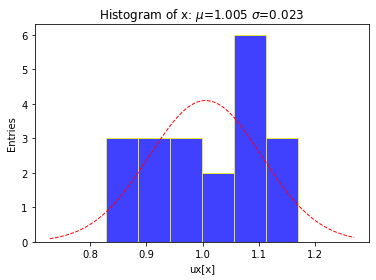

In [17]:
get_histogram(x,'Histogram of x:',"ux[x]","Entries",gauss=True,fig_name=None)


Prima iterazione (incertezze sulle x trascurate)
m         =  2.1214
sigma(m)  =  0.2235
c         =  2.8631
sigma(c)  =  0.2257
cov(m, c) =  -0.0502
rho(m, c) =  -0.9951


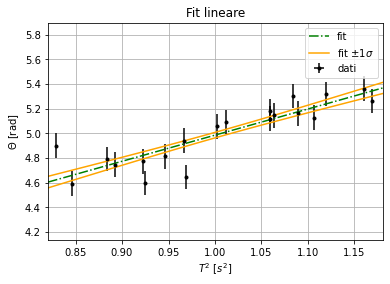


Seconda iterazione incertezze sulle x non trascurate
m         =  2.1214
sigma(m)  =  0.2285
c         =  2.8631
sigma(c)  =  0.2308
cov(m, c) =  -0.0525
rho(m, c) =  -0.9951


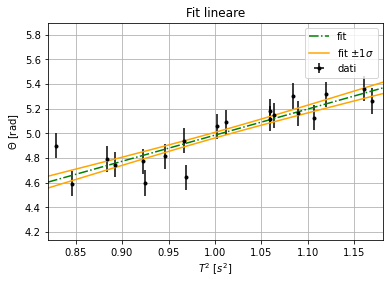


Studio Residui


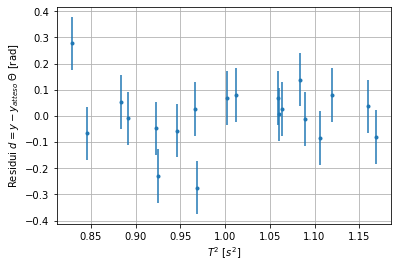

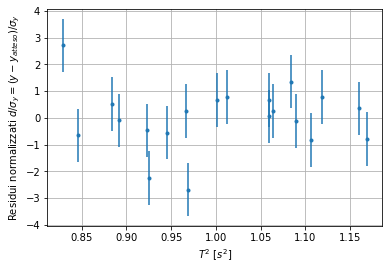


Test chi^2
chi2 misurato:  27.5
ndf:  18
chi2 mis./ndf:  1.53

p_value=0.0700833455088532 > 0.05
Test del Chi2 al livello di significatività alpha=0.05 superato

Con incertezze a posteriori 

Incertezze a posteriori=0.12360327804440852
m         =  2.1214
sigma(m)  =  0.2762
c         =  2.8631
sigma(c)  =  0.279
cov(m, c) =  -0.0767
rho(m, c) =  -0.9951


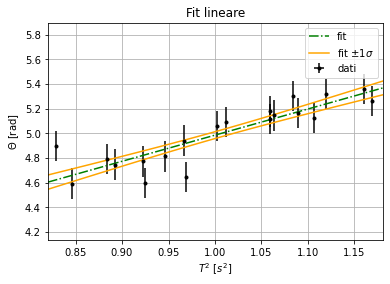

In [18]:
fit_res = fit(x,y,sx,sy,"$T^2$ [$s^2$]","$\Theta$ [rad]",0.01,0.1,True,"fit") 

In [19]:
#fit_res

In [20]:
FitValues(x,y,sy)

x_mean: 1.005142053583489
y_mean: 4.9953459989598255
x_2_mean: 1.0203217195511733
xy_mean: 5.042269681484802
var_x: 0.010011171669140007
cov_xy: 0.02123734573025793
w_y: 1999.9999999999998


In [21]:
y_from_fit(1.20,0,fit_res[2])

(5.408710759159886, 0.06050708600707136)